<div style="font-size:18pt; padding-top:20px; text-align:center"><b>ДОМАШНЕЕ ЗАДАНИЕ 3. Классификация текстовых документов</b> </div><hr>
<div style="text-align:right;">Папулин С.Ю. <span style="font-style: italic;font-weight: bold;">(papulin.study@yandex.ru)</span></div>

# Цель работы

Получение опыта решения практических задач по машинному обучению, таких как анализ и визуализация исходных данных, обучение, выбор и оценка качества моделей предсказания с помощью языка программирования Python.

<p>Подключение стилей оформления</p>

In [217]:
%%html
<link href="css/style.css" rel="stylesheet" type="text/css">

# Вариант

<p>Чтобы узнать свой вариант, введите Вашу фамилию в соответвующее поле ниже и запустите ячейку:</p>

In [218]:
surname = "Малкина" # Ваша фамилия

alp = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
w = [4, 42, 21, 21, 34,  1, 44, 26, 18, 43, 38, 26, 18, 43,  3, 49, 45,
        7, 42, 25,  4,  9, 36, 33, 31, 29,  5, 31,  4, 19, 24, 27, 33]
d = dict(zip(alp, w))
variant =  sum([d[el] for el in surname.lower()]) % 3 + 1
print("Ваш вариант - ", variant)

Ваш вариант -  1


<div class="msg-block msg-warning">
  <p class="msg-text-warn">Варианты могут не совпадать с последующими ДЗ</p>
</div>

<ol>
    <li>
        Набор электронных сообщений (emails) - <b>спам/не спам</b> - <a href="http://csmining.org/index.php/spam-email-datasets-.html">источник</a> - файл c данными: <b>data/emails.tsv</b>
    </li>
    <li>
        Набор SMS сообщений (sms) - <b>спам/не спам</b> - <a href="https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection">источник</a> - файл c данными: <b>data/SMSSpamCollection</b>
    </li>
    <li>Набор рецензий на фильмы (reviews) - <b>positive/negative</b> - <a href="http://www.cs.cornell.edu/people/pabo/movie-review-data/">источник</a> - файл c данными: <b>data/reviews.tsv</b></li>
</ol>

⚠️ Замечание.

Для всех объектов/методов/моделей random_state = 123

# Import

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
%load_ext autoreload
%autoreload 2

# import sys
# sys.path.insert(0, "../lib/")
# from plot_confusion_matrix import plot_confusion_matrix


import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV


import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import balanced_accuracy_score,recall_score,precision_score,f1_score

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
        cross_val_score, 
    cross_validate

)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Задание 1. Оценка качества фильтрации текстовых данных (2 балла)

<ol>
    <li>Загрузите исходные данные</li>
    <li>Разбейте загруженные данные на обучающее (train, 80%) и тестовое подмножества (test, 20%)</li>
    <li>Переведите текстовые данные в векторный вид. Для этого воспользуйтесь средствами sklearn для конвертации текста в векторы TF-IDF (настроить на обучающем подмножестве, n-gram=1, слова в нижний регистр). Примечание: для модели Бернулли используйте бинарный вектор.</li>
    <li>Постройте на обучающем подмножестве следующие модели классификации:
        <ul>
            <li>K-ближайших соседей ($n=5$)</li>
            <li>Логистическая регрессия ($C=1$)</li>
            <li>Наивный Байес: модель Бернулли ($\alpha=1$)</li> 
            <li>Наивный Байес: полиномиальная модель ($\alpha=1$)</li> 
        </ul>
    </li>
    <li>Определите качество классификации на тестовом подмножестве (Balanced-Accuracy, R, P, F1)</li>
    <li>Определите с время обучения и предсказания (на тестовом подмножестве)</li>
    <li>Свести все значения в один датафрейм и представить результат в виде таблицы</li>
</ol>



---



In [220]:
random_state = 123  # для всех объектов/методов/моделей
# Параметры логистической регрессии
# penalty="l2" , fit_intercept=True, max_iter=100, C=1, solver="lbfgs", random_state=123

In [221]:
#В первую очередь создам датафрейм и его представление в виде таблицы
index = ["K-ближайших соседей", "Логистическая регрессия", "Наивный Байес: модель Бернулли", "Наивный Байес: полиномиальная модель"]
columns = ["Balanced-Accuracy", "R", "P", "F1", "Time fit", "Time predict"]
df = pd.DataFrame(index=index, columns=columns)

⚠️ Замечание (к коду выше) - DataFrame заполняется в процессе взаимодействия с моделями

In [222]:
# Загрузите исходные данные
data = pd.read_csv("https://raw.githubusercontent.com/Carpediem2026/ML/main/Dz3/emails.tsv", sep='\t')

In [223]:
#Разбейте загруженные данные на обучающее (train, 80%) и тестовое подмножества (test, 20%)
x = np.array(data['emails'])
y = np.array(data['type'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)

In [224]:
#Переведите текстовые данные в векторный вид. 
#Для этого воспользуйтесь средствами sklearn для конвертации текста в векторы TF-IDF (настроить на обучающем подмножестве, n-gram=1, слова в нижний регистр). 
#Примечание: для модели Бернулли используйте бинарный вектор.
vectorizer = TfidfVectorizer(lowercase=True, stop_words="english",#None, 
                             use_idf=True, ngram_range=(1,1),
                             smooth_idf=False)

#Передаем набор документов, на основе которых будут строиться векторы
vectorizer = vectorizer.fit(X_train)
# Преобразование текстовых документов в векторы
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test.astype('U'))

**Модели классификаций**

> K-ближайших соседей ($n=5$)





In [225]:
#K-ближайших соседей
from sklearn.neighbors import KNeighborsClassifier
# Создание и обучение модели
knn_model = KNeighborsClassifier(n_neighbors=5, p=2,)
start_time1 = time.time()
knn_model.fit(train_vectors, y_train)
time1 = time.time() - start_time1
print(f"Time fit = {time1}")
df.loc['K-ближайших соседей','Time fit'] = time1
# Предсказания для тестового подмножества
start_time2 = time.time()
y_test_pred_knn = knn_model.predict(test_vectors)
time2 = time.time() - start_time2
print(f"Time predict = {time2}")
df.loc['K-ближайших соседей','Time predict'] = time2
# Определите качество классификации на тестовом подмножестве (Balanced-Accuracy, R, P, F1)
balanced_accuracy_model = balanced_accuracy_score(y_test,y_test_pred_knn)
recall_score_model = recall_score(y_test,y_test_pred_knn)
precision_score_model = precision_score(y_test,y_test_pred_knn)
f1_score_model = f1_score(y_test,y_test_pred_knn)
print(f"Test balanced accuracy = {balanced_accuracy_model}")
print(f"Test recall score = {recall_score_model}")
print(f"Test precision score = {precision_score_model}")
print(f"Test f1 score = {f1_score_model}")
df.loc['K-ближайших соседей','Balanced-Accuracy'] = balanced_accuracy_model
df.loc['K-ближайших соседей','R'] = recall_score_model
df.loc['K-ближайших соседей','P'] = precision_score_model
df.loc['K-ближайших соседей','F1'] = f1_score_model

Time fit = 0.0029325485229492188
Time predict = 0.2946591377258301
Test balanced accuracy = 0.6069980422937287
Test recall score = 0.2281303602058319
Test precision score = 0.9708029197080292
Test f1 score = 0.3694444444444444




> Логистическая регрессия ($C=1$)



In [226]:
#Логистическая регрессия
from sklearn.linear_model import LogisticRegression
# Создание и обучение модели
logreg_model = LogisticRegression(penalty="l2", fit_intercept=True, max_iter=100, C=1, solver="lbfgs", random_state=12345)
start_time1 = time.time()
logreg_model.fit(train_vectors, y_train)
time1 = time.time() - start_time1
print(f"Time fit = {time1}")
df.loc['Логистическая регрессия','Time fit'] = time1
# Предсказания для тестового подмножества
start_time2 = time.time()
y_test_pred_loreg = logreg_model.predict(test_vectors)
time2 = time.time() - start_time2
print(f"Time predict = {time2}")
df.loc['Логистическая регрессия','Time predict'] = time2
# Определите качество классификации на тестовом подмножестве (Balanced-Accuracy, R, P, F1)
balanced_accuracy_model = balanced_accuracy_score(y_test,y_test_pred_loreg)
recall_score_model = recall_score(y_test,y_test_pred_loreg)
precision_score_model = precision_score(y_test,y_test_pred_loreg)
f1_score_model = f1_score(y_test,y_test_pred_loreg)
print(f"Test balanced accuracy = {balanced_accuracy_model}")
print(f"Test recall score = {recall_score_model}")
print(f"Test precision score = {precision_score_model}")
print(f"Test f1 score = {f1_score_model}")
df.loc['Логистическая регрессия','Balanced-Accuracy'] = balanced_accuracy_model
df.loc['Логистическая регрессия','R'] = recall_score_model
df.loc['Логистическая регрессия','P'] = precision_score_model
df.loc['Логистическая регрессия','F1'] = f1_score_model

Time fit = 0.5263385772705078
Time predict = 0.0013036727905273438
Test balanced accuracy = 0.9542181599985453
Test recall score = 0.9897084048027445
Test precision score = 0.9616666666666667
Test f1 score = 0.9754860524091294



> Наивный Байес: полиномиальная модель ($\alpha=1$)



In [227]:
#Наивный Байес: полиномиальная модель
from sklearn.naive_bayes import MultinomialNB
# Создание и обучение модели
m_multNB = MultinomialNB(alpha=1)
start_time1 = time.time()
m_multNB.fit(train_vectors, y_train)
time1 = time.time() - start_time1
print(f"Time fit = {time1}")
df.loc['Наивный Байес: полиномиальная модель','Time fit'] = time1
# Предсказания для тестового подмножества
start_time2 = time.time()
y_test_pred_multNB = m_multNB.predict(test_vectors)
time2 = time.time() - start_time2
print(f"Time predict = {time2}")
df.loc['Наивный Байес: полиномиальная модель','Time predict'] = time2
# Определите качество классификации на тестовом подмножестве (Balanced-Accuracy, R, P, F1)
balanced_accuracy_model = balanced_accuracy_score(y_test,y_test_pred_multNB)
recall_score_model = recall_score(y_test,y_test_pred_multNB)
precision_score_model = precision_score(y_test,y_test_pred_multNB)
f1_score_model = f1_score(y_test,y_test_pred_multNB)
print(f"Test balanced accuracy = {balanced_accuracy_model}")
print(f"Test recall score = {recall_score_model}")
print(f"Test precision score = {precision_score_model}")
print(f"Test f1 score = {f1_score_model}")
df.loc['Наивный Байес: полиномиальная модель','Balanced-Accuracy'] = balanced_accuracy_model
df.loc['Наивный Байес: полиномиальная модель','R'] = recall_score_model
df.loc['Наивный Байес: полиномиальная модель','P'] = precision_score_model
df.loc['Наивный Байес: полиномиальная модель','F1'] = f1_score_model

Time fit = 0.009627819061279297
Time predict = 0.0037245750427246094
Test balanced accuracy = 0.8365981974555879
Test recall score = 0.9982847341337907
Test precision score = 0.8635014836795252
Test f1 score = 0.9260143198090692




> Наивный Байес: модель Бернулли ($\alpha=1$)



In [228]:
#Наивный Байес: модель Бернулли
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
# Создание преобразователя текстовых документов в бинарные векторы с указанием параметров
count_vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,1),
                                   stop_words=None, lowercase=True,
                                   binary=True, strip_accents=None)

# Преобразование текстовых документов в бинарные векторы
train_binary_vectors = count_vectorizer.fit_transform(X_train)
test_binary_vectors = count_vectorizer.transform(X_test.astype('U'))
# Создание и обучение модели
m_bernNB = BernoulliNB(alpha=1, binarize=None)
start_time1 = time.time()
m_bernNB.fit(train_binary_vectors, y_train)
time1 = time.time() - start_time1
print(f"Time fit = {time1}")
df.loc['Наивный Байес: модель Бернулли','Time fit'] = time1
# Предсказания для тестового подмножества
start_time2 = time.time()
y_test_pred_bernNB = m_bernNB.predict(test_binary_vectors)
time2 = time.time() - start_time2
print(f"Time predict = {time2}")
df.loc['Наивный Байес: модель Бернулли','Time predict'] = time2
# Определите качество классификации на тестовом подмножестве (Balanced-Accuracy, R, P, F1)
balanced_accuracy_model = balanced_accuracy_score(y_test,y_test_pred_bernNB)
recall_score_model = recall_score(y_test,y_test_pred_bernNB)
precision_score_model = precision_score(y_test,y_test_pred_bernNB)
f1_score_model = f1_score(y_test,y_test_pred_bernNB)
print(f"Test balanced accuracy = {balanced_accuracy_model}")
print(f"Test recall score = {recall_score_model}")
print(f"Test precision score = {precision_score_model}")
print(f"Test f1 score = {f1_score_model}")
df.loc['Наивный Байес: модель Бернулли','Balanced-Accuracy'] = balanced_accuracy_model
df.loc['Наивный Байес: модель Бернулли','R'] = recall_score_model
df.loc['Наивный Байес: модель Бернулли','P'] = precision_score_model
df.loc['Наивный Байес: модель Бернулли','F1'] = f1_score_model

Time fit = 0.00889134407043457
Time predict = 0.007122993469238281
Test balanced accuracy = 0.6805726442368886
Test recall score = 0.9759862778730704
Test precision score = 0.765814266487214
Test f1 score = 0.8582202111613875


⚠️ Замечание - пункты 5-6 задания выполнялись в процессе взаимодействия с моделями

⚠️ Замечание - пункт 7 задания. Датафрейм создан и заполнен выше

In [229]:
print("Представление результатов в виде таблицы:")
df

Представление результатов в виде таблицы:


,Balanced-Accuracy,R,P,F1,Time fit,Time predict
K-ближайших соседей,0.606998,0.22813,0.970803,0.369444,0.002933,0.294659
Логистическая регрессия,0.954218,0.989708,0.961667,0.975486,0.526339,0.001304
Наивный Байес: модель Бернулли,0.680573,0.975986,0.765814,0.85822,0.008891,0.007123
Наивный Байес: полиномиальная модель,0.836598,0.998285,0.863501,0.926014,0.009628,0.003725


# Задание 2. Оценка качества классификации текстовых данных посредством кросс-валидации (2 балла)

<p>Повторите решение задачи 1, но с использованием k-folds (k=4) для разделения исходных данных</p>


---



In [230]:
random_state = 123  # для всех объектов/методов/моделей

In [231]:
#Создан новый датафрейм
df_2 = pd.DataFrame(index=index, columns=columns)
# Изменение метода разделения исходных данных, под "(k=4)" подразумевается n_splits=4
kf = StratifiedKFold(n_splits=4, random_state=random_state,shuffle = True)
for train_index, test_index in kf.split(x,y):
  X2_train, X2_test = x[train_index], x[test_index]
  y2_train, y2_test = y[train_index], y[test_index]
#Переведите текстовые данные в векторный вид. vectorizer используется из прошлого задания, так как он не зависит от способо разделения исходных данных
#Передаем набор документов, на основе которых будут строиться векторы
vectorizer = vectorizer.fit(X2_train.astype('U'))
# Преобразование текстовых документов в векторы
train_vectors2 = vectorizer.fit_transform(X2_train.astype('U'))
test_vectors2 = vectorizer.transform(X2_test.astype('U'))

# Модели классификаций

> K-ближайших соседей ($n=5$)


In [232]:
#K-ближайших соседей
# Создание и обучение модели
knn_model = KNeighborsClassifier(n_neighbors=5, p=2,)
score = cross_validate(knn_model, train_vectors2, y2_train, cv=kf, scoring=['f1_macro','recall_macro','precision_macro','balanced_accuracy'])
time1 = score['fit_time'].mean()
print(f"Time fit = {time1}")
df_2.loc['K-ближайших соседей','Time fit'] = time1
time2 = score['score_time'].mean()
print(f"Time predict = {time2}")
df_2.loc['K-ближайших соседей','Time predict'] = time2
# Определите качество классификации на тестовом подмножестве (Balanced-Accuracy, R, P, F1)
balanced_accuracy_model = score['test_balanced_accuracy'].mean()
recall_score_model = score['test_recall_macro'].mean()
precision_score_model = score['test_precision_macro'].mean()
f1_score_model = score['test_f1_macro'].mean()
print(f"Test balanced accuracy = {balanced_accuracy_model}")
print(f"Test recall score = {recall_score_model}")
print(f"Test precision score = {precision_score_model}")
print(f"Test f1 score = {f1_score_model}")
df_2.loc['K-ближайших соседей','Balanced-Accuracy'] = balanced_accuracy_model
df_2.loc['K-ближайших соседей','R'] = recall_score_model
df_2.loc['K-ближайших соседей','P'] = precision_score_model
df_2.loc['K-ближайших соседей','F1'] = f1_score_model

Time fit = 0.0056427717208862305
Time predict = 0.16428202390670776
Test balanced accuracy = 0.5558940123591558
Test recall score = 0.5558940123591558
Test precision score = 0.6494637602386517
Test f1 score = 0.36505615346076


> Логистическая регрессия ($C=1$)


In [233]:
#Логистическая регрессия
# Создание и обучение модели
logreg_model = LogisticRegression(penalty="l2", fit_intercept=True, max_iter=100, C=1, solver="lbfgs", random_state=12345)
score = cross_validate(logreg_model, train_vectors2, y2_train, cv=kf, scoring=['f1_macro','recall_macro','precision_macro','balanced_accuracy'])
time1 = score['fit_time'].mean()
print(f"Time fit = {time1}")
df_2.loc['Логистическая регрессия','Time fit'] = time1
time2 = score['score_time'].mean()
print(f"Time predict = {time2}")
df_2.loc['Логистическая регрессия','Time predict'] = time2
# Определите качество классификации на тестовом подмножестве (Balanced-Accuracy, R, P, F1)
balanced_accuracy_model = score['test_balanced_accuracy'].mean()
recall_score_model = score['test_recall_macro'].mean()
precision_score_model = score['test_precision_macro'].mean()
f1_score_model = score['test_f1_macro'].mean()
print(f"Test balanced accuracy = {balanced_accuracy_model}")
print(f"Test recall score = {recall_score_model}")
print(f"Test precision score = {precision_score_model}")
print(f"Test f1 score = {f1_score_model}")
df_2.loc['Логистическая регрессия','Balanced-Accuracy'] = balanced_accuracy_model
df_2.loc['Логистическая регрессия','R'] = recall_score_model
df_2.loc['Логистическая регрессия','P'] = precision_score_model
df_2.loc['Логистическая регрессия','F1'] = f1_score_model

Time fit = 0.5216562151908875
Time predict = 0.008052289485931396
Test balanced accuracy = 0.921522606729183
Test recall score = 0.921522606729183
Test precision score = 0.9555179295473879
Test f1 score = 0.9359615396960568


> Наивный Байес: полиномиальная модель ($\alpha=1$)

In [234]:
#Наивный Байес: полиномиальная модель
# Создание и обучение модели
m_multNB = MultinomialNB(alpha=1)
score = cross_validate(m_multNB, train_vectors2, y2_train, cv=kf, scoring=['f1_macro','recall_macro','precision_macro','balanced_accuracy'])
time1 = score['fit_time'].mean()
print(f"Time fit = {time1}")
time2 = score['score_time'].mean()
print(f"Time predict = {time2}")
# Определите качество классификации на тестовом подмножестве (Balanced-Accuracy, R, P, F1)
balanced_accuracy_model = score['test_balanced_accuracy'].mean()
recall_score_model = score['test_recall_macro'].mean()
precision_score_model = score['test_precision_macro'].mean()
f1_score_model = score['test_f1_macro'].mean()
print(f"Test balanced accuracy = {balanced_accuracy_model}")
print(f"Test recall score = {recall_score_model}")
print(f"Test precision score = {precision_score_model}")
print(f"Test f1 score = {f1_score_model}")
df_2.loc['Наивный Байес: полиномиальная модель','Time fit'] = time1
df_2.loc['Наивный Байес: полиномиальная модель','Time predict'] = time2
df_2.loc['Наивный Байес: полиномиальная модель','Balanced-Accuracy'] = balanced_accuracy_model
df_2.loc['Наивный Байес: полиномиальная модель','R'] = recall_score_model
df_2.loc['Наивный Байес: полиномиальная модель','P'] = precision_score_model
df_2.loc['Наивный Байес: полиномиальная модель','F1'] = f1_score_model

Time fit = 0.01488584280014038
Time predict = 0.005890786647796631
Test balanced accuracy = 0.7751906728209348
Test recall score = 0.7751906728209348
Test precision score = 0.9115378093776904
Test f1 score = 0.8070908552324512


> Наивный Байес: модель Бернулли ($\alpha=1$)


In [235]:
#Наивный Байес: модель Бернулли
# Преобразование текстовых документов в бинарные векторы. count_vectorizer используется из прошлого задания, так как он не зависит от способa разделения исходных данных
train_binary_vectors2 = count_vectorizer.fit_transform(X2_train.astype('U'))
test_binary_vectors2 = count_vectorizer.transform(X2_test.astype('U'))
# Создание и обучение модели
m_bernNB = BernoulliNB(alpha=1, binarize=None)
score = cross_validate(m_bernNB, train_binary_vectors2, y2_train, cv=kf, scoring=['f1_macro','recall_macro','precision_macro','balanced_accuracy'])
time1 = score['fit_time'].mean()
print(f"Time fit = {time1}")
time2 = score['score_time'].mean()
print(f"Time predict = {time2}")
# Определите качество классификации на тестовом подмножестве (Balanced-Accuracy, R, P, F1)
balanced_accuracy_model = score['test_balanced_accuracy'].mean()
recall_score_model = score['test_recall_macro'].mean()
precision_score_model = score['test_precision_macro'].mean()
f1_score_model = score['test_f1_macro'].mean()
print(f"Test balanced accuracy = {balanced_accuracy_model}")
print(f"Test recall score = {recall_score_model}")
print(f"Test precision score = {precision_score_model}")
print(f"Test f1 score = {f1_score_model}")
df_2.loc['Наивный Байес: модель Бернулли','Time fit'] = time1
df_2.loc['Наивный Байес: модель Бернулли','Time predict'] = time2
df_2.loc['Наивный Байес: модель Бернулли','Balanced-Accuracy'] = balanced_accuracy_model
df_2.loc['Наивный Байес: модель Бернулли','R'] = recall_score_model
df_2.loc['Наивный Байес: модель Бернулли','P'] = precision_score_model
df_2.loc['Наивный Байес: модель Бернулли','F1'] = f1_score_model

Time fit = 0.011403083801269531
Time predict = 0.011103987693786621
Test balanced accuracy = 0.663605861582057
Test recall score = 0.663605861582057
Test precision score = 0.8145506787893184
Test f1 score = 0.6779037475926984


⚠️ Замечание - пункты 5-6 задания выполнялись в процессе взаимодействия с моделями

⚠️ Замечание - пункт 7 задания. Датафрейм создан и заполнен выше

In [236]:
print("Представление результатов в виде таблицы:")
df_2

Представление результатов в виде таблицы:


,Balanced-Accuracy,R,P,F1,Time fit,Time predict
K-ближайших соседей,0.555894,0.555894,0.649464,0.365056,0.005643,0.164282
Логистическая регрессия,0.921523,0.921523,0.955518,0.935962,0.521656,0.008052
Наивный Байес: модель Бернулли,0.663606,0.663606,0.814551,0.677904,0.011403,0.011104
Наивный Байес: полиномиальная модель,0.775191,0.775191,0.911538,0.807091,0.014886,0.005891


# Задание 3. Выбор модели (4 баллов)

<p style="padding-left:15px;">1. Используя данные из задачи 1, разбейте обучающее подмножество (train) с использованием k-folds (k=4) <br>
2. Обучите и протестируйте на разбитом обучающем подмножестве классификаторы со следующими параметрами: </p>

<p>K-ближайших соседей</p>

In [237]:
ns = np.arange(1, 150, 20)  # количество соседей

<p>Логистическая регрессия</p>

In [238]:
cs = np.logspace(-2, 10, 8, base=10)  # параметр регуляризации

Наивный Байес: модель Бернулли

In [239]:
alphas = np.logspace(-4, 1, 8, base=10)  # сглаживающий параметр

<p>Наивный Байес: полиномиальная модель </p>

In [240]:
alphas = np.logspace(-4, 1, 8, base=10)  # сглаживающий параметр

<p style="padding-left:15px;">3. Постройте графики (параметры модели)-(Balanced-Accuracy) при обучении и валидации <br>
4. Выберите лучшую модель для каждого метода, используя значение качества классификации (использовать Balanced-Accuracy)<br>
5. Выбранные модели обучите на обучающем подмножестве (train) и протестируйте на тестовом (test). Определите время обучения и предсказания (см. задачу 1 п. 6)<br>
6. Повторите шаги 2-4 для n-gram=2 и n-gram=(1,2)<br>
7. Выведите в виде таблицы итоговые данные по всем методам для лучших моделей (метод, n-gram, значение параметра модели, время обучения, время предсказания, метрики (Balanced-Accuracy, R, P, F1))<br>
8. Сделайте выводы по полученным результатам (преимущества и недостатки методов)
</p>



---



In [241]:
random_state = 123  # для всех объектов/методов/моделей

⚠️ Замечание - т.к. в задании написано "разбейте обучающее подмножество (train) с использованием k-folds (k=4)", то разбивается подмножество (train) из задания №1 на подмножества train и test

In [242]:
#В первую очередь создам датафрейм и его представление в виде таблицы
index = range(0,12)
columns = ["method","n-gram", "Value_best",  "Time fit", "Time predict", "Balanced-Accuracy", "R", "P", "F1"]
df_3 = pd.DataFrame(index=index, columns=columns)

In [243]:
# Изменение метода разделения исходных данных, под "(k=4)" подразумевается n_splits=4
kf = StratifiedKFold(n_splits=4, random_state=random_state,shuffle = True)
for train_index, test_index in kf.split(X_train,y_train):
  X3_train, X3_test = X_train[train_index], X_train[test_index]
  y3_train, y3_test = y_train[train_index], y_train[test_index]
#Передаем набор документов, на основе которых будут строиться векторы
vectorizer = vectorizer.fit(X3_train)
# Преобразование текстовых документов в векторы
train_vectors3 = vectorizer.fit_transform(X3_train)
test_vectors3 = vectorizer.transform(X3_test.astype('U'))

# Модели классификаций

> K-ближайших соседей

In [244]:
from sklearn.pipeline import Pipeline

def knn(train_vectors3, y3_train):
  global scores_test_knn,best_n
  best_acc = 0
  print("K-ближайших соседей")
  pipeline = Pipeline([
      ("knn_model", KNeighborsClassifier(n_neighbors=None, p=2))
  ])
  for n in ns:
      pipeline.named_steps["knn_model"]. n_neighbors = n
      score = cross_validate(pipeline, train_vectors3, y3_train, cv=kf, scoring=['balanced_accuracy'])
      balanced_accuracy_model = score['test_balanced_accuracy'].mean()
      scores_test_knn.append(balanced_accuracy_model)
      if best_acc < balanced_accuracy_model:
          best_acc = balanced_accuracy_model
          best_n = n
      print('balanced_accuracy на тестовом подмножестве - {}, при n_neighbors - {}'.format(balanced_accuracy_model,n))
  print("Best n_neighbors :", best_n)
scores_test_knn=[] 
best_n = 0
knn(train_vectors3, y3_train)

K-ближайших соседей
balanced_accuracy на тестовом подмножестве - 0.6451067454477546, при n_neighbors - 1
balanced_accuracy на тестовом подмножестве - 0.698782205235572, при n_neighbors - 21
balanced_accuracy на тестовом подмножестве - 0.9145424347839479, при n_neighbors - 41
balanced_accuracy на тестовом подмножестве - 0.9091841969622981, при n_neighbors - 61
balanced_accuracy на тестовом подмножестве - 0.9072752933026828, при n_neighbors - 81
balanced_accuracy на тестовом подмножестве - 0.9023760398121563, при n_neighbors - 101
balanced_accuracy на тестовом подмножестве - 0.9007029257947288, при n_neighbors - 121
balanced_accuracy на тестовом подмножестве - 0.8876817069484374, при n_neighbors - 141
Best n_neighbors : 41



> Логистическая регрессия



In [245]:
def logreg(train_vectors3, y3_train):
  global scores_test_logreg, best_c
  best_acc = 0
  print("Логистическая регрессия")
  pipeline = Pipeline([
      ("logreg_model", LogisticRegression(penalty="l2", fit_intercept=True, max_iter=100, C=None, solver="lbfgs", random_state=12345))
  ])
  for c in cs:
      pipeline.named_steps["logreg_model"]. C = c
      score = cross_validate(pipeline, train_vectors3, y3_train, cv=kf, scoring=['balanced_accuracy'])
      #scores = cross_val_score(pipeline, train_vectors3, y3_train, cv=kf)
      balanced_accuracy_model = score['test_balanced_accuracy'].mean()
      scores_test_logreg.append(balanced_accuracy_model)
      if best_acc < balanced_accuracy_model:
          best_acc = balanced_accuracy_model
          best_c = c
      print('balanced_accuracy на тестовом подмножестве - {}, при C - {}'.format(balanced_accuracy_model,c))
  print("Best C :", best_c)
scores_test_logreg=[]  
best_c  = 0
logreg(train_vectors3, y3_train)

Логистическая регрессия
balanced_accuracy на тестовом подмножестве - 0.5, при C - 0.01
balanced_accuracy на тестовом подмножестве - 0.8698112289643423, при C - 0.517947467923121
balanced_accuracy на тестовом подмножестве - 0.968480069116572, при C - 26.826957952797247
balanced_accuracy на тестовом подмножестве - 0.9689422352482497, при C - 1389.4954943731361
balanced_accuracy на тестовом подмножестве - 0.9683804432079023, при C - 71968.56730011514
balanced_accuracy на тестовом подмножестве - 0.9658497217070031, при C - 3727593.720314938
balanced_accuracy на тестовом подмножестве - 0.9583549739171813, при C - 193069772.88832456
balanced_accuracy на тестовом подмножестве - 0.9561507880239709, при C - 10000000000.0
Best C : 1389.4954943731361



> Наивный Байес: полиномиальная модель



In [246]:
def multNB(train_vectors3, y3_train,test_vectors3,y3_test):
  global scores_test_multNB, best_alpha_multNB
  best_acc = 0
  print("Наивный Байес: полиномиальная модель")
  pipeline = Pipeline([
      ("m_multNB", MultinomialNB(alpha=None))
  ])
  for alpha in alphas:
      pipeline.named_steps["m_multNB"].alpha = alpha
      score = cross_validate(pipeline, train_vectors3, y3_train, cv=kf, scoring=['balanced_accuracy'])
      #scores = cross_val_score(pipeline, train_vectors3, y3_train, cv=kf)
      balanced_accuracy_model = score['test_balanced_accuracy'].mean()     
      scores_test_multNB.append(balanced_accuracy_model)
      if best_acc < balanced_accuracy_model:
          best_acc = balanced_accuracy_model
          best_alpha_multNB = alpha
      print('balanced_accuracy на тестовом подмножестве - {}, при alpha - {}'.format(balanced_accuracy_model,alpha))
  print("Best alpha :", best_alpha_multNB)
scores_test_multNB=[] 
best_alpha_multNB = 0
multNB(train_vectors3, y3_train,test_vectors3,y3_test)

Наивный Байес: полиномиальная модель
balanced_accuracy на тестовом подмножестве - 0.9507525519030057, при alpha - 0.0001
balanced_accuracy на тестовом подмножестве - 0.9526732997306108, при alpha - 0.0005179474679231213
balanced_accuracy на тестовом подмножестве - 0.9540728110145211, при alpha - 0.002682695795279727
balanced_accuracy на тестовом подмножестве - 0.9573972030717453, при alpha - 0.013894954943731374
balanced_accuracy на тестовом подмножестве - 0.9500971562179293, при alpha - 0.07196856730011521
balanced_accuracy на тестовом подмножестве - 0.8985944092365634, при alpha - 0.3727593720314942
balanced_accuracy на тестовом подмножестве - 0.6945651414497613, при alpha - 1.9306977288832496
balanced_accuracy на тестовом подмножестве - 0.5255801562869997, при alpha - 10.0
Best alpha : 0.013894954943731374


> Наивный Байес: модель Бернулли

In [247]:
def bernNB(y3_train,y3_test):
  global train_binary_vectors33, test_binary_vectors33, scores_test_bernNB, best_alpha_bernNB
  best_acc = 0
  print("Наивный Байес: модель Бернулли")
  pipeline = Pipeline([
      ("m_bernNB", BernoulliNB(alpha=None, binarize=None))
  ])
  for alpha in alphas:
      pipeline.named_steps["m_bernNB"]. alpha = alpha
      score = cross_validate(pipeline, train_binary_vectors33, y3_train, cv=kf, scoring=['balanced_accuracy'])
      #scores = cross_val_score(pipeline, train_vectors3, y3_train, cv=kf)
      balanced_accuracy_model = score['test_balanced_accuracy'].mean() 
      scores_test_bernNB.append(balanced_accuracy_model)
      if best_acc < balanced_accuracy_model:
          best_acc = balanced_accuracy_model
          best_alpha_bernNB = alpha
      print('balanced_accuracy на тестовом подмножестве - {}, при alpha - {}'.format(balanced_accuracy_model,alpha))
  print("Best alpha :", best_alpha_bernNB)


train_binary_vectors33 = count_vectorizer.fit_transform(X3_train.astype('U'))
test_binary_vectors33 = count_vectorizer.transform(X3_test.astype('U'))
scores_test_bernNB=[] 
best_alpha_bernNB = 0
bernNB(y3_train,y3_test)

Наивный Байес: модель Бернулли
balanced_accuracy на тестовом подмножестве - 0.8704732567213451, при alpha - 0.0001
balanced_accuracy на тестовом подмножестве - 0.8699125181279803, при alpha - 0.0005179474679231213
balanced_accuracy на тестовом подмножестве - 0.8675225112419327, при alpha - 0.002682695795279727
balanced_accuracy на тестовом подмножестве - 0.86212978139122, при alpha - 0.013894954943731374
balanced_accuracy на тестовом подмножестве - 0.8458170147620763, при alpha - 0.07196856730011521
balanced_accuracy на тестовом подмножестве - 0.7860369797771743, при alpha - 0.3727593720314942
balanced_accuracy на тестовом подмножестве - 0.5978748013514594, при alpha - 1.9306977288832496
balanced_accuracy на тестовом подмножестве - 0.5208432400569882, при alpha - 10.0
Best alpha : 0.0001


# Графики

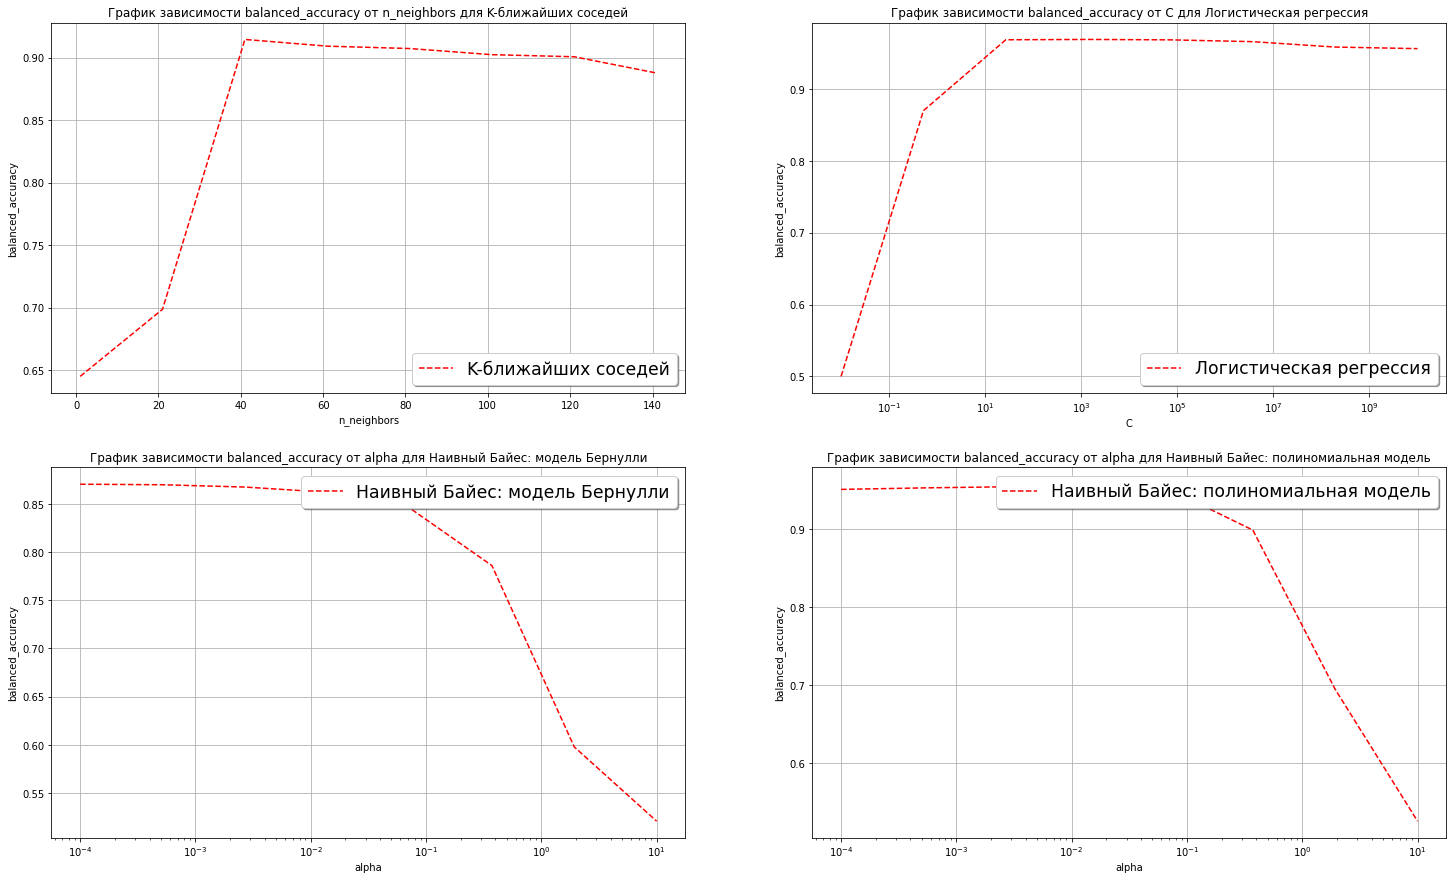

In [248]:
#Постройте графики (параметры модели)-(Balanced-Accuracy) при обучении и валидации
plt.figure(1, figsize=[25, 15])
plt.subplot(2,2,1)
plt.plot(ns, scores_test_knn, color="red", label = 'K-ближайших соседей', ls = 'dashed')
plt.xlabel("n_neighbors")
plt.ylabel("balanced_accuracy")
plt.title('График зависимости balanced_accuracy от n_neighbors для K-ближайших соседей')
plt.grid(True)
plt.legend(loc=4, shadow=True, fontsize='xx-large')

plt.subplot(2,2,2)
plt.plot(cs, scores_test_logreg, color="red", label = 'Логистическая регрессия', ls = 'dashed')
plt.xlabel("C")
plt.ylabel("balanced_accuracy")
plt.title('График зависимости balanced_accuracy от C для Логистическая регрессия')
plt.grid(True)
plt.xscale('log')
plt.legend(loc=4, shadow=True, fontsize='xx-large')

plt.subplot(2,2,3)
plt.plot(alphas, scores_test_bernNB, color="red", label = 'Наивный Байес: модель Бернулли', ls = 'dashed')
plt.xlabel("alpha")
plt.ylabel("balanced_accuracy")
plt.title('График зависимости balanced_accuracy от alpha для Наивный Байес: модель Бернулли')
plt.grid(True)
plt.xscale('log')
plt.legend(loc=1, shadow=True, fontsize='xx-large')

plt.subplot(2,2,4)
plt.plot(alphas, scores_test_multNB, color="red", label = 'Наивный Байес: полиномиальная модель', ls = 'dashed')
plt.xlabel("alpha")
plt.ylabel("balanced_accuracy")
plt.title('График зависимости balanced_accuracy от alpha для Наивный Байес: полиномиальная модель')
plt.grid(True)
plt.xscale('log')
plt.legend(loc=1, shadow=True, fontsize='xx-large')

plt.show()

# Лучшие модели



In [249]:
#Выберите лучшую модель для каждого метода, используя значение качества классификации (использовать Balanced-Accuracy)
print("Best models:")
print("Best K-ближайших соседей n_neighbors - ", best_n)
print("Best Логистическая регрессия C - ", best_c)
print("Best Наивный Байес: полиномиальная модель alpha - ", best_alpha_multNB)
print("Best Наивный Байес: модель Бернулли alpha - ", best_alpha_bernNB)

Best models:
Best K-ближайших соседей n_neighbors -  41
Best Логистическая регрессия C -  1389.4954943731361
Best Наивный Байес: полиномиальная модель alpha -  0.013894954943731374
Best Наивный Байес: модель Бернулли alpha -  0.0001


In [250]:
#Выбранные модели обучите на обучающем подмножестве (train) и протестируйте на тестовом (test). Определите время обучения и предсказания (см. задачу 1 п. 6)

def best_knn(df,index,train_vectors3, y3_train,test_vectors3,y3_test):
  global best_n,gram
  #K-ближайших соседей
  print("K-ближайших соседей")
  # Создание и обучение модели
  knn_model = KNeighborsClassifier(n_neighbors=best_n, p=2,)
  score = cross_validate(knn_model, train_vectors3, y3_train, cv=kf, scoring=['f1_macro','recall_macro','precision_macro','balanced_accuracy'])
  time1 = score['fit_time'].mean()
  print(f"Time fit = {time1}")
  time2 = score['score_time'].mean()
  print(f"Time predict = {time2}")
  # Определите качество классификации на тестовом подмножестве (Balanced-Accuracy, R, P, F1)
  balanced_accuracy_model = score['test_balanced_accuracy'].mean()
  recall_score_model = score['test_recall_macro'].mean()
  precision_score_model = score['test_precision_macro'].mean()
  f1_score_model = score['test_f1_macro'].mean()
  print(f"Test balanced accuracy = {balanced_accuracy_model}")
  print(f"Test recall score = {recall_score_model}")
  print(f"Test precision score = {precision_score_model}")
  print(f"Test f1 score = {f1_score_model}")
  df.loc[index,'Time fit'] = time1
  df.loc[index,'Time predict'] = time2
  df.loc[index,'Value_best'] = best_n
  df.loc[index,'n-gram'] = gram
  df.loc[index,'method'] = 'K-ближайших соседей'
  df.loc[index,'Balanced-Accuracy'] = balanced_accuracy_model
  df.loc[index,'R'] = recall_score_model
  df.loc[index,'P'] = precision_score_model
  df.loc[index,'F1'] = f1_score_model
gram = 1 
best_knn(df_3,0,train_vectors3, y3_train,test_vectors3,y3_test)

K-ближайших соседей
Time fit = 0.0037189126014709473
Time predict = 0.11257272958755493
Test balanced accuracy = 0.9145424347839479
Test recall score = 0.9145424347839479
Test precision score = 0.8846552255283217
Test f1 score = 0.8957747251589554


In [251]:
def best_logreg(df,index,train_vectors3, y3_train,test_vectors3,y3_test):
  global best_c,gram
  #Логистическая регрессия
  print("Логистическая регрессия")
  # Создание и обучение модели
  logreg_model = LogisticRegression(penalty="l2", fit_intercept=True, max_iter=100, C=best_c, solver="lbfgs", random_state=12345)
  score = cross_validate(logreg_model, train_vectors3, y3_train, cv=kf, scoring=['f1_macro','recall_macro','precision_macro','balanced_accuracy'])
  time1 = score['fit_time'].mean()
  print(f"Time fit = {time1}")
  time2 = score['score_time'].mean()
  print(f"Time predict = {time2}")
  # Определите качество классификации на тестовом подмножестве (Balanced-Accuracy, R, P, F1)
  balanced_accuracy_model = score['test_balanced_accuracy'].mean()
  recall_score_model = score['test_recall_macro'].mean()
  precision_score_model = score['test_precision_macro'].mean()
  f1_score_model = score['test_f1_macro'].mean()
  print(f"Test balanced accuracy = {balanced_accuracy_model}")
  print(f"Test recall score = {recall_score_model}")
  print(f"Test precision score = {precision_score_model}")
  print(f"Test f1 score = {f1_score_model}")
  df.loc[index,'Time fit'] = time1
  df.loc[index,'Time predict'] = time2
  df.loc[index,'Value_best'] = best_c
  df.loc[index,'n-gram'] = gram
  df.loc[index,'method'] = 'Логистическая регрессия'
  df.loc[index,'Balanced-Accuracy'] = balanced_accuracy_model
  df.loc[index,'R'] = recall_score_model
  df.loc[index,'P'] = precision_score_model
  df.loc[index,'F1'] = f1_score_model
best_logreg(df_3,3,train_vectors3, y3_train,test_vectors3,y3_test)

Логистическая регрессия
Time fit = 1.444276750087738
Time predict = 0.008858680725097656
Test balanced accuracy = 0.9689422352482497
Test recall score = 0.9689422352482497
Test precision score = 0.9663420913323375
Test f1 score = 0.9675776372038534


In [252]:
def best_multNB(df,index,train_vectors3, y3_train,test_vectors3,y3_test):
  global best_alpha_multNB,gram
  #Наивный Байес: полиномиальная модель
  print("Наивный Байес: полиномиальная модель")
  # Создание и обучение модели
  m_multNB = MultinomialNB(alpha=best_alpha_multNB)
  score = cross_validate(m_multNB, train_vectors3, y3_train, cv=kf, scoring=['f1_macro','recall_macro','precision_macro','balanced_accuracy'])
  time1 = score['fit_time'].mean()
  print(f"Time fit = {time1}")
  time2 = score['score_time'].mean()
  print(f"Time predict = {time2}")
  # Определите качество классификации на тестовом подмножестве (Balanced-Accuracy, R, P, F1)
  balanced_accuracy_model = score['test_balanced_accuracy'].mean()
  recall_score_model = score['test_recall_macro'].mean()
  precision_score_model = score['test_precision_macro'].mean()
  f1_score_model = score['test_f1_macro'].mean()
  print(f"Test balanced accuracy = {balanced_accuracy_model}")
  print(f"Test recall score = {recall_score_model}")
  print(f"Test precision score = {precision_score_model}")
  print(f"Test f1 score = {f1_score_model}")
  df.loc[index,'Time fit'] = time1
  df.loc[index,'Time predict'] = time2
  df.loc[index,'Value_best'] = best_alpha_multNB
  df.loc[index,'n-gram'] = gram
  df.loc[index,'method'] = 'Наивный Байес: полиномиальная модель'
  df.loc[index,'Balanced-Accuracy'] = balanced_accuracy_model
  df.loc[index,'R'] = recall_score_model
  df.loc[index,'P'] = precision_score_model
  df.loc[index,'F1'] = f1_score_model
best_multNB(df_3,6,train_vectors3, y3_train,test_vectors3,y3_test)

Наивный Байес: полиномиальная модель
Time fit = 0.008489251136779785
Time predict = 0.004615426063537598
Test balanced accuracy = 0.9573972030717453
Test recall score = 0.9573972030717453
Test precision score = 0.9486575892030349
Test f1 score = 0.9527850209177651


In [253]:
def best_bernNB(df,index,y3_train,y3_test):
  global best_alpha_bernNB,train_binary_vectors33, test_binary_vectors33,gram
  #Наивный Байес: модель Бернулли
  print("Наивный Байес: модель Бернулли")
  # Создание и обучение модели
  m_bernNB = BernoulliNB(alpha=best_alpha_bernNB, binarize=None)
  score = cross_validate(m_bernNB, train_binary_vectors33, y3_train, cv=kf, scoring=['f1_macro','recall_macro','precision_macro','balanced_accuracy'])
  time1 = score['fit_time'].mean()
  print(f"Time fit = {time1}")
  time2 = score['score_time'].mean()
  print(f"Time predict = {time2}")
  # Определите качество классификации на тестовом подмножестве (Balanced-Accuracy, R, P, F1)
  balanced_accuracy_model = score['test_balanced_accuracy'].mean()
  recall_score_model = score['test_recall_macro'].mean()
  precision_score_model = score['test_precision_macro'].mean()
  f1_score_model = score['test_f1_macro'].mean()
  print(f"Test balanced accuracy = {balanced_accuracy_model}")
  print(f"Test recall score = {recall_score_model}")
  print(f"Test precision score = {precision_score_model}")
  print(f"Test f1 score = {f1_score_model}")
  df.loc[index,'Time fit'] = time1
  df.loc[index,'Time predict'] = time2
  df.loc[index,'Value_best'] = best_alpha_bernNB
  df.loc[index,'n-gram'] = gram
  df.loc[index,'method'] = 'Наивный Байес: модель Бернулли'
  df.loc[index,'Balanced-Accuracy'] = balanced_accuracy_model
  df.loc[index,'R'] = recall_score_model
  df.loc[index,'P'] = precision_score_model
  df.loc[index,'F1'] = f1_score_model
best_bernNB(df_3,9,y3_train,y3_test)

Наивный Байес: модель Бернулли
Time fit = 0.008928060531616211
Time predict = 0.009302914142608643
Test balanced accuracy = 0.8704732567213451
Test recall score = 0.8704732567213451
Test precision score = 0.914590172768948
Test f1 score = 0.8879739293780001


In [254]:
#Выведите в виде таблицы итоговые данные по всем методам для лучших моделей (метод, n-gram, значение параметра модели, время обучения, время предсказания, метрики (Balanced-Accuracy, R, P, F1))
df_3

,method,n-gram,Value_best,Time fit,Time predict,Balanced-Accuracy,R,P,F1
0,K-ближайших соседей,1,41,0.003719,0.112573,0.914542,0.914542,0.884655,0.895775
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Логистическая регрессия,1,1389.495494,1.444277,0.008859,0.968942,0.968942,0.966342,0.967578
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Наивный Байес: полиномиальная модель,1,0.013895,0.008489,0.004615,0.957397,0.957397,0.948658,0.952785
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Наивный Байес: модель Бернулли,1,0.0001,0.008928,0.009303,0.870473,0.870473,0.91459,0.887974




# n-gram=2



In [255]:
vectorizer = TfidfVectorizer(lowercase=True, stop_words="english",#None, 
                             use_idf=True, ngram_range=(2,2),
                             smooth_idf=False)

#Передаем набор документов, на основе которых будут строиться векторы
vectorizer32 = vectorizer.fit(X3_train)
# Преобразование текстовых документов в векторы
train_vectors32 = vectorizer32.fit_transform(X3_train)
test_vectors32 = vectorizer32.transform(X3_test.astype('U'))

In [256]:
# Повторите шаги 2-4 для n-gram=2 и n-gram=(1,2)
#Шаг 2
scores_test_knn=[] 
best_n = 0
knn(train_vectors32, y3_train)
print('----------------------------')
scores_test_logreg=[]  
best_c  = 0
logreg(train_vectors32, y3_train)
print('----------------------------')
scores_test_multNB=[] 
best_alpha_multNB = 0
multNB(train_vectors32, y3_train,test_vectors32,y3_test)
print('----------------------------')
count_vectorizer2 = CountVectorizer(analyzer="word", ngram_range=(2,2),
                                   stop_words=None, lowercase=True,
                                   binary=True, strip_accents=None)
train_binary_vectors33 = count_vectorizer2.fit_transform(X3_train.astype('U'))
test_binary_vectors33 = count_vectorizer2.transform(X3_test.astype('U'))
scores_test_bernNB=[] 
best_alpha_bernNB = 0
bernNB(y3_train,y3_test)

K-ближайших соседей
balanced_accuracy на тестовом подмножестве - 0.5822072413078166, при n_neighbors - 1
balanced_accuracy на тестовом подмножестве - 0.600979378803458, при n_neighbors - 21
balanced_accuracy на тестовом подмножестве - 0.895258226795806, при n_neighbors - 41
balanced_accuracy на тестовом подмножестве - 0.8702457059128095, при n_neighbors - 61
balanced_accuracy на тестовом подмножестве - 0.8257176216826163, при n_neighbors - 81
balanced_accuracy на тестовом подмножестве - 0.806090298328336, при n_neighbors - 101
balanced_accuracy на тестовом подмножестве - 0.7923663724669544, при n_neighbors - 121
balanced_accuracy на тестовом подмножестве - 0.7825917145432, при n_neighbors - 141
Best n_neighbors : 41
----------------------------
Логистическая регрессия
balanced_accuracy на тестовом подмножестве - 0.5, при C - 0.01
balanced_accuracy на тестовом подмножестве - 0.6217913805351646, при C - 0.517947467923121
balanced_accuracy на тестовом подмножестве - 0.9019293390442542, пр

In [257]:
#Выберите лучшую модель для каждого метода, используя значение качества классификации (использовать Balanced-Accuracy)
print("Best models:")
print("Best K-ближайших соседей n_neighbors - ", best_n)
print("Best Логистическая регрессия C - ", best_c)
print("Best Наивный Байес: полиномиальная модель alpha - ", best_alpha_multNB)
print("Best Наивный Байес: модель Бернулли alpha - ", best_alpha_bernNB)

Best models:
Best K-ближайших соседей n_neighbors -  41
Best Логистическая регрессия C -  10000000000.0
Best Наивный Байес: полиномиальная модель alpha -  0.0001
Best Наивный Байес: модель Бернулли alpha -  0.0001


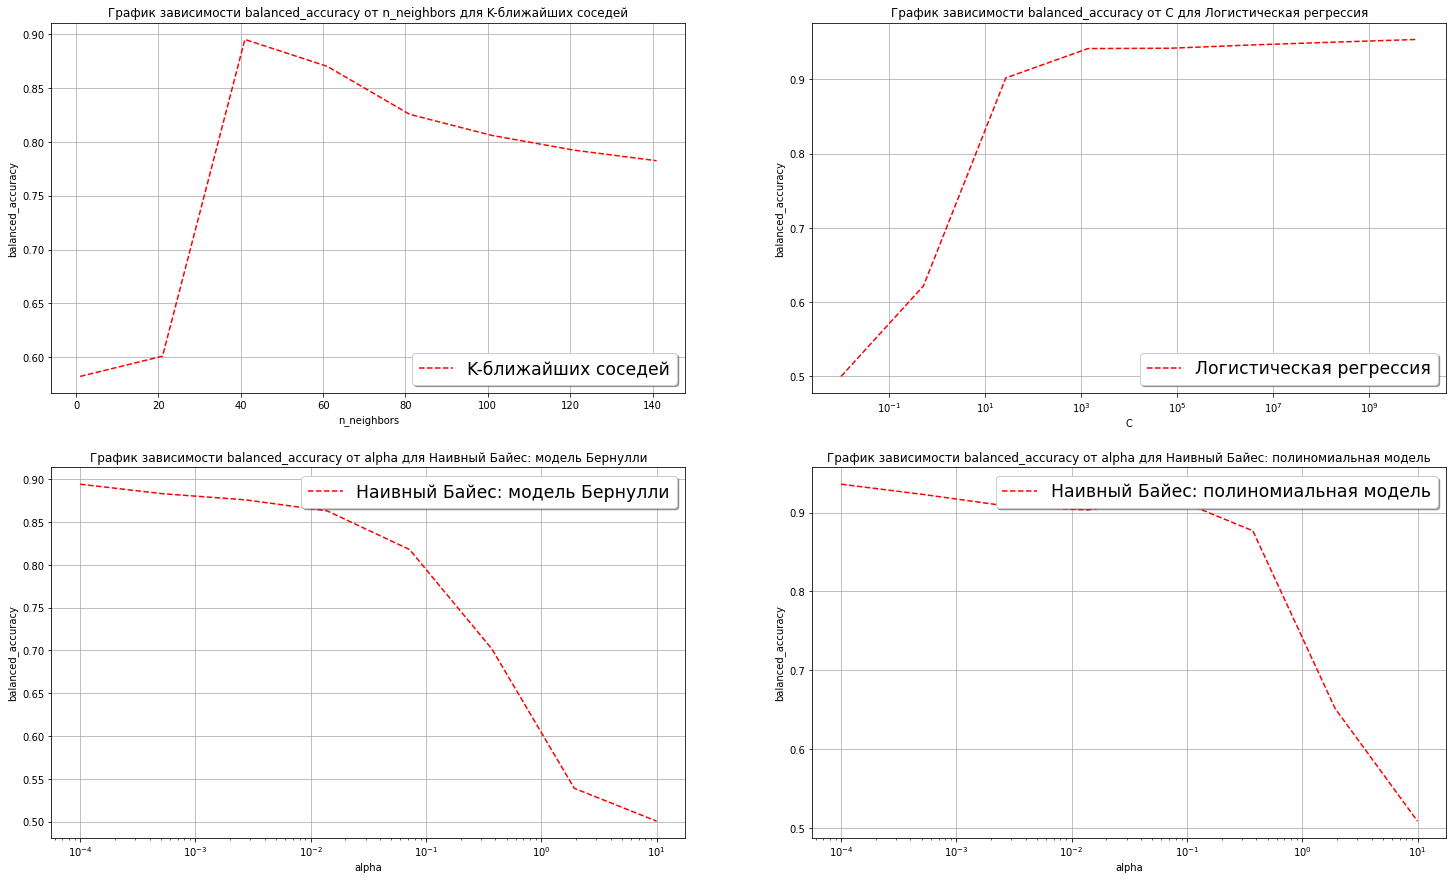

In [258]:
#Постройте графики (параметры модели)-(Balanced-Accuracy) при обучении и валидации
plt.figure(1, figsize=[25, 15])
plt.subplot(2,2,1)
plt.plot(ns, scores_test_knn, color="red", label = 'K-ближайших соседей', ls = 'dashed')
plt.xlabel("n_neighbors")
plt.ylabel("balanced_accuracy")
plt.title('График зависимости balanced_accuracy от n_neighbors для K-ближайших соседей')
plt.grid(True)
plt.legend(loc=4, shadow=True, fontsize='xx-large')

plt.subplot(2,2,2)
plt.plot(cs, scores_test_logreg, color="red", label = 'Логистическая регрессия', ls = 'dashed')
plt.xlabel("C")
plt.ylabel("balanced_accuracy")
plt.title('График зависимости balanced_accuracy от C для Логистическая регрессия')
plt.grid(True)
plt.xscale('log')
plt.legend(loc=4, shadow=True, fontsize='xx-large')

plt.subplot(2,2,3)
plt.plot(alphas, scores_test_bernNB, color="red", label = 'Наивный Байес: модель Бернулли', ls = 'dashed')
plt.xlabel("alpha")
plt.ylabel("balanced_accuracy")
plt.title('График зависимости balanced_accuracy от alpha для Наивный Байес: модель Бернулли')
plt.grid(True)
plt.xscale('log')
plt.legend(loc=1, shadow=True, fontsize='xx-large')

plt.subplot(2,2,4)
plt.plot(alphas, scores_test_multNB, color="red", label = 'Наивный Байес: полиномиальная модель', ls = 'dashed')
plt.xlabel("alpha")
plt.ylabel("balanced_accuracy")
plt.title('График зависимости balanced_accuracy от alpha для Наивный Байес: полиномиальная модель')
plt.grid(True)
plt.xscale('log')
plt.legend(loc=1, shadow=True, fontsize='xx-large')

plt.show()

In [259]:
#Шаг 
gram = 2
best_knn(df_3,1,train_vectors3, y3_train,test_vectors3,y3_test)
print('----------------------------')
best_logreg(df_3,4,train_vectors3, y3_train,test_vectors3,y3_test)
print('----------------------------')
best_multNB(df_3,7,train_vectors3, y3_train,test_vectors3,y3_test)
print('----------------------------')

count_vectorizer2 = CountVectorizer(analyzer="word", ngram_range=(2,2),
                                   stop_words=None, lowercase=True,
                                   binary=True, strip_accents=None)
train_binary_vectors33 = count_vectorizer2.fit_transform(X3_train.astype('U'))
test_binary_vectors33 = count_vectorizer2.transform(X3_test.astype('U'))
best_bernNB(df_3,10,y3_train,y3_test)

K-ближайших соседей
Time fit = 0.004318416118621826
Time predict = 0.12294411659240723
Test balanced accuracy = 0.9145424347839479
Test recall score = 0.9145424347839479
Test precision score = 0.8846552255283217
Test f1 score = 0.8957747251589554
----------------------------
Логистическая регрессия
Time fit = 0.5116226673126221
Time predict = 0.009075820446014404
Test balanced accuracy = 0.9561507880239709
Test recall score = 0.9561507880239709
Test precision score = 0.9662552190732623
Test f1 score = 0.960762413074542
----------------------------
Наивный Байес: полиномиальная модель
Time fit = 0.014602959156036377
Time predict = 0.008481740951538086
Test balanced accuracy = 0.9507525519030057
Test recall score = 0.9507525519030057
Test precision score = 0.9496947825198288
Test f1 score = 0.9501582651848614
----------------------------
Наивный Байес: модель Бернулли
Time fit = 0.03297626972198486
Time predict = 0.03208303451538086
Test balanced accuracy = 0.8941419845191394
Test recall



# n-gram=(1,2)



In [260]:
vectorizer = TfidfVectorizer(lowercase=True, stop_words="english",#None, 
                             use_idf=True, ngram_range=(1,2),
                             smooth_idf=False)

#Передаем набор документов, на основе которых будут строиться векторы
vectorizer33 = vectorizer.fit(X3_train)
# Преобразование текстовых документов в векторы
train_vectors33 = vectorizer33.fit_transform(X3_train)
test_vectors33 = vectorizer33.transform(X3_test.astype('U'))

In [261]:
# Повторите шаги 2-4 для n-gram=2 и n-gram=(1,2)
#Шаг 2
scores_test_knn=[] 
best_n = 0
knn(train_vectors33, y3_train)
print('----------------------------')
scores_test_logreg=[]  
best_c  = 0
logreg(train_vectors33, y3_train)
print('----------------------------')
scores_test_multNB=[] 
best_alpha_multNB = 0
multNB(train_vectors33, y3_train,test_vectors33,y3_test)
print('----------------------------')
count_vectorizer2 = CountVectorizer(analyzer="word", ngram_range=(1,2),
                                   stop_words=None, lowercase=True,
                                   binary=True, strip_accents=None)
train_binary_vectors33 = count_vectorizer2.fit_transform(X3_train.astype('U'))
test_binary_vectors33 = count_vectorizer2.transform(X3_test.astype('U'))
scores_test_bernNB=[] 
best_alpha_bernNB = 0
bernNB(y3_train,y3_test)

K-ближайших соседей
balanced_accuracy на тестовом подмножестве - 0.6005233141526706, при n_neighbors - 1
balanced_accuracy на тестовом подмножестве - 0.7016473911421746, при n_neighbors - 21
balanced_accuracy на тестовом подмножестве - 0.9092783620481292, при n_neighbors - 41
balanced_accuracy на тестовом подмножестве - 0.8970575868073661, при n_neighbors - 61
balanced_accuracy на тестовом подмножестве - 0.8901362748659898, при n_neighbors - 81
balanced_accuracy на тестовом подмножестве - 0.8879718612088316, при n_neighbors - 101
balanced_accuracy на тестовом подмножестве - 0.8859314385113294, при n_neighbors - 121
balanced_accuracy на тестовом подмножестве - 0.8827571827091849, при n_neighbors - 141
Best n_neighbors : 41
----------------------------
Логистическая регрессия
balanced_accuracy на тестовом подмножестве - 0.5, при C - 0.01
balanced_accuracy на тестовом подмножестве - 0.7646065376694005, при C - 0.517947467923121
balanced_accuracy на тестовом подмножестве - 0.96046112480199

In [262]:
#Выберите лучшую модель для каждого метода, используя значение качества классификации (использовать Balanced-Accuracy)
print("Best models:")
print("Best K-ближайших соседей n_neighbors - ", best_n)
print("Best Логистическая регрессия C - ", best_c)
print("Best Наивный Байес: полиномиальная модель alpha - ", best_alpha_multNB)
print("Best Наивный Байес: модель Бернулли alpha - ", best_alpha_bernNB)

Best models:
Best K-ближайших соседей n_neighbors -  41
Best Логистическая регрессия C -  71968.56730011514
Best Наивный Байес: полиномиальная модель alpha -  0.0001
Best Наивный Байес: модель Бернулли alpha -  0.0001


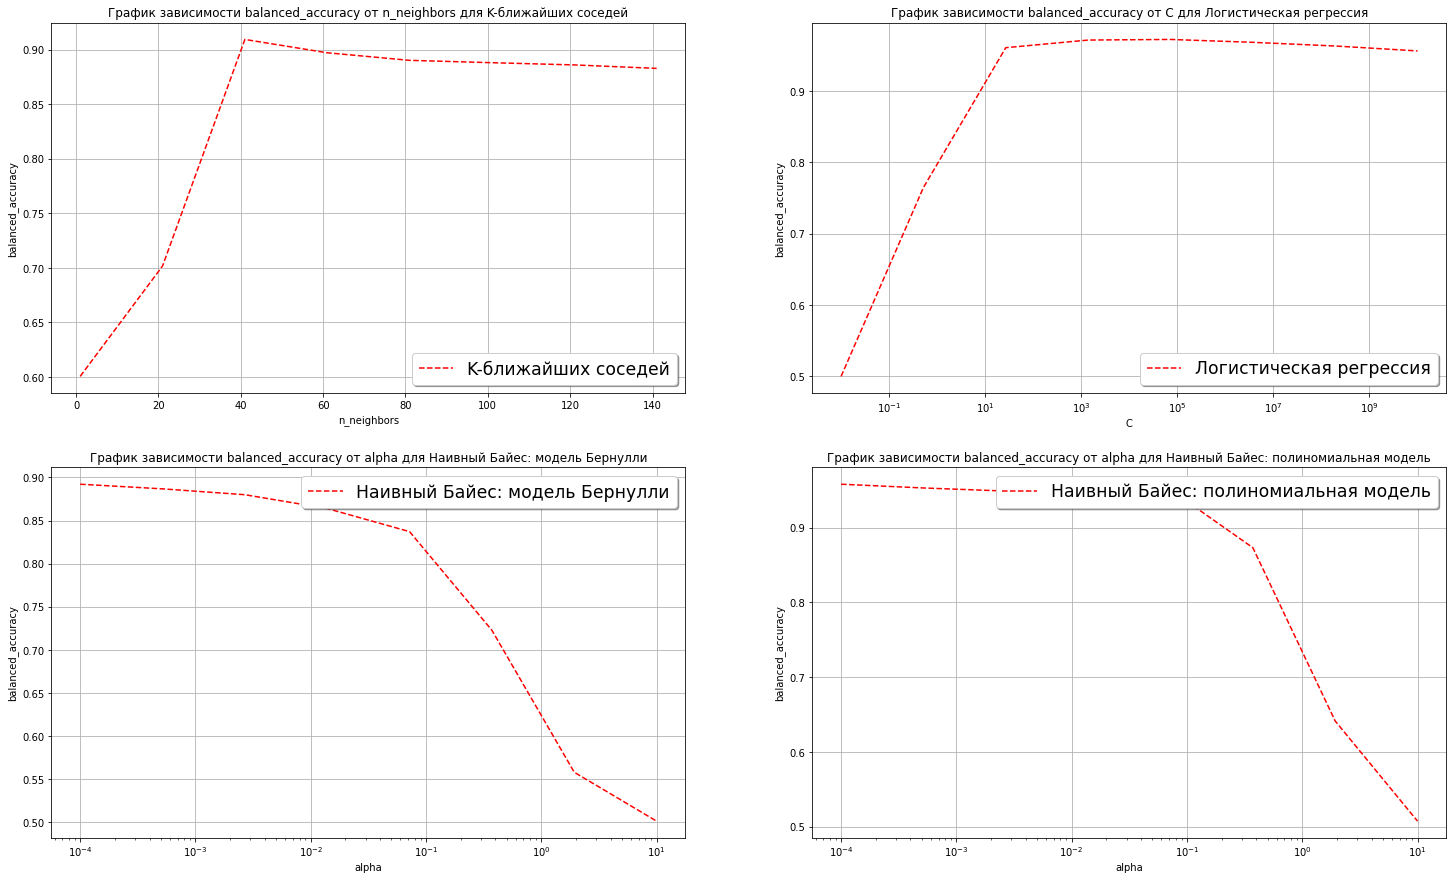

In [263]:
#Постройте графики (параметры модели)-(Balanced-Accuracy) при обучении и валидации
plt.figure(1, figsize=[25, 15])
plt.subplot(2,2,1)
plt.plot(ns, scores_test_knn, color="red", label = 'K-ближайших соседей', ls = 'dashed')
plt.xlabel("n_neighbors")
plt.ylabel("balanced_accuracy")
plt.title('График зависимости balanced_accuracy от n_neighbors для K-ближайших соседей')
plt.grid(True)
plt.legend(loc=4, shadow=True, fontsize='xx-large')

plt.subplot(2,2,2)
plt.plot(cs, scores_test_logreg, color="red", label = 'Логистическая регрессия', ls = 'dashed')
plt.xlabel("C")
plt.ylabel("balanced_accuracy")
plt.title('График зависимости balanced_accuracy от C для Логистическая регрессия')
plt.grid(True)
plt.xscale('log')
plt.legend(loc=4, shadow=True, fontsize='xx-large')

plt.subplot(2,2,3)
plt.plot(alphas, scores_test_bernNB, color="red", label = 'Наивный Байес: модель Бернулли', ls = 'dashed')
plt.xlabel("alpha")
plt.ylabel("balanced_accuracy")
plt.title('График зависимости balanced_accuracy от alpha для Наивный Байес: модель Бернулли')
plt.grid(True)
plt.xscale('log')
plt.legend(loc=1, shadow=True, fontsize='xx-large')

plt.subplot(2,2,4)
plt.plot(alphas, scores_test_multNB, color="red", label = 'Наивный Байес: полиномиальная модель', ls = 'dashed')
plt.xlabel("alpha")
plt.ylabel("balanced_accuracy")
plt.title('График зависимости balanced_accuracy от alpha для Наивный Байес: полиномиальная модель')
plt.grid(True)
plt.xscale('log')
plt.legend(loc=1, shadow=True, fontsize='xx-large')

plt.show()

In [264]:
#Шаг 
gram = "1,2"
best_knn(df_3,2,train_vectors3, y3_train,test_vectors3,y3_test)
print('----------------------------')
best_logreg(df_3,5,train_vectors3, y3_train,test_vectors3,y3_test)
print('----------------------------')
best_multNB(df_3,8,train_vectors3, y3_train,test_vectors3,y3_test)
print('----------------------------')
best_bernNB(df_3,11,y3_train,y3_test)

K-ближайших соседей
Time fit = 0.0035492777824401855
Time predict = 0.11496144533157349
Test balanced accuracy = 0.9145424347839479
Test recall score = 0.9145424347839479
Test precision score = 0.8846552255283217
Test f1 score = 0.8957747251589554
----------------------------
Логистическая регрессия
Time fit = 1.3902071118354797
Time predict = 0.008358180522918701
Test balanced accuracy = 0.9683804432079023
Test recall score = 0.9683804432079023
Test precision score = 0.9651426288263218
Test f1 score = 0.9667085198235521
----------------------------
Наивный Байес: полиномиальная модель
Time fit = 0.016542494297027588
Time predict = 0.01034015417098999
Test balanced accuracy = 0.9507525519030057
Test recall score = 0.9507525519030057
Test precision score = 0.9496947825198288
Test f1 score = 0.9501582651848614
----------------------------
Наивный Байес: модель Бернулли
Time fit = 0.038012027740478516
Time predict = 0.04575979709625244
Test balanced accuracy = 0.8921799261658541
Test reca

In [265]:
#Выведите в виде таблицы итоговые данные по всем методам для лучших моделей (метод, n-gram, значение параметра модели, время обучения, время предсказания, метрики (Balanced-Accuracy, R, P, F1))
df_3

,method,n-gram,Value_best,Time fit,Time predict,Balanced-Accuracy,R,P,F1
0,K-ближайших соседей,1,41,0.003719,0.112573,0.914542,0.914542,0.884655,0.895775
1,K-ближайших соседей,2,41,0.004318,0.122944,0.914542,0.914542,0.884655,0.895775
2,K-ближайших соседей,"1,2",41,0.003549,0.114961,0.914542,0.914542,0.884655,0.895775
3,Логистическая регрессия,1,1389.495494,1.444277,0.008859,0.968942,0.968942,0.966342,0.967578
4,Логистическая регрессия,2,10000000000.0,0.511623,0.009076,0.956151,0.956151,0.966255,0.960762
5,Логистическая регрессия,"1,2",71968.5673,1.390207,0.008358,0.96838,0.96838,0.965143,0.966709
6,Наивный Байес: полиномиальная модель,1,0.013895,0.008489,0.004615,0.957397,0.957397,0.948658,0.952785
7,Наивный Байес: полиномиальная модель,2,0.0001,0.014603,0.008482,0.950753,0.950753,0.949695,0.950158
8,Наивный Байес: полиномиальная модель,"1,2",0.0001,0.016542,0.01034,0.950753,0.950753,0.949695,0.950158
9,Наивный Байес: модель Бернулли,1,0.0001,0.008928,0.009303,0.870473,0.870473,0.91459,0.887974


Сделайте выводы по полученным результатам (преимущества и недостатки методов).

K-ближайших соседей. + Простота реализации. Примерно одинаковое время для разных параметров.

Логистическая регрессия. -Занимает больше времени.Общая точность не очень высокая

Наивный Байес: модель Бернулли. + стабильную эффективность классификации.

Наивный Байес: полиномиальная модель.   -менее стабильная эффективность классификации (по сравнению с моделью бернулии).+самая быстрая





# Задание 4. Оценка влияния количества признаков FeatureHasher на качество классификации (2 баллов)

<p>Как будет меняться качество классификации для обозначенных ранее методов при использовании FeatureHasher (или HashingVectorizer) из пакета sklearn перед TF-IDF преобразованием, если</p>

In [266]:
n_features = np.logspace(1, 5, 5, base=10)  # количество признаков
non_negative=True

⚠️ Замечания
*   Используйте лучшие модели из задания 3 при 1-gram
*   Для FeatureHasher/HashingVectorizer установите следующие параметры: norm=None и alternate_sign=False

<p>Можно воспользоваться GridSearchCV</p>

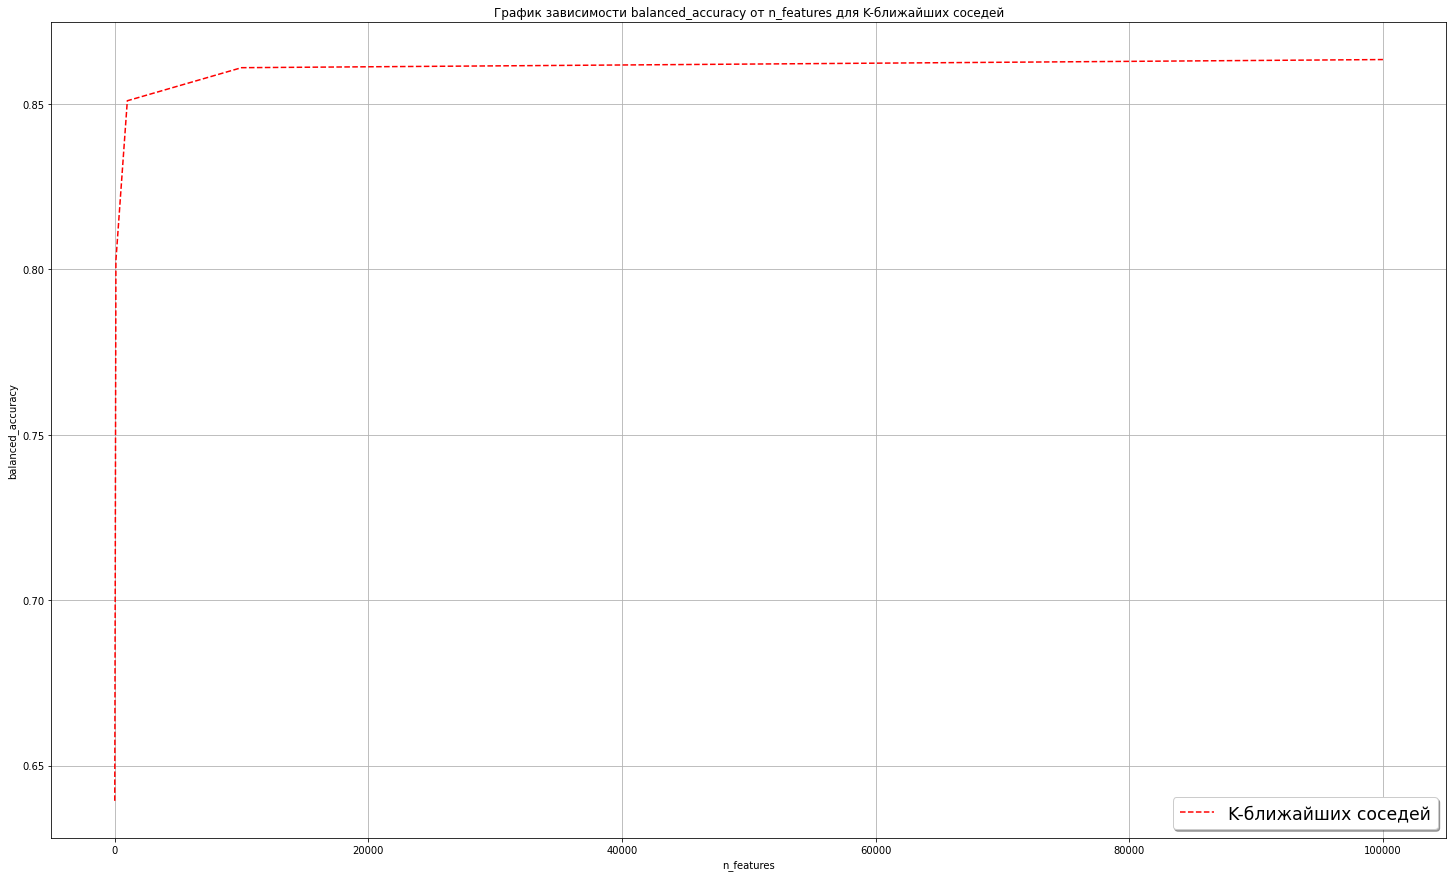

In [267]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
scores_test_knn=[]

for n in n_features:
  pipeline = Pipeline([
                        ("hashing", HashingVectorizer(norm=None,alternate_sign=False,n_features =int(n), ngram_range=(1,1))),
                       ("transformer", TfidfTransformer()),
                        ("knn_model", KNeighborsClassifier(n_neighbors=df_3.iloc[0]['Value_best']))
  ])
  score = cross_validate(pipeline, X_train, y_train, cv=kf, scoring=['balanced_accuracy'])
  balanced_accuracy_model = score['test_balanced_accuracy'].mean()
  scores_test_knn.append(balanced_accuracy_model)

plt.figure(1, figsize=[25, 15])
plt.plot(n_features, scores_test_knn, color="red", label = 'K-ближайших соседей', ls = 'dashed')
plt.xlabel("n_features")
plt.ylabel("balanced_accuracy")
plt.title('График зависимости balanced_accuracy от n_features для K-ближайших соседей')
plt.grid(True)
plt.legend(loc=4, shadow=True, fontsize='xx-large')

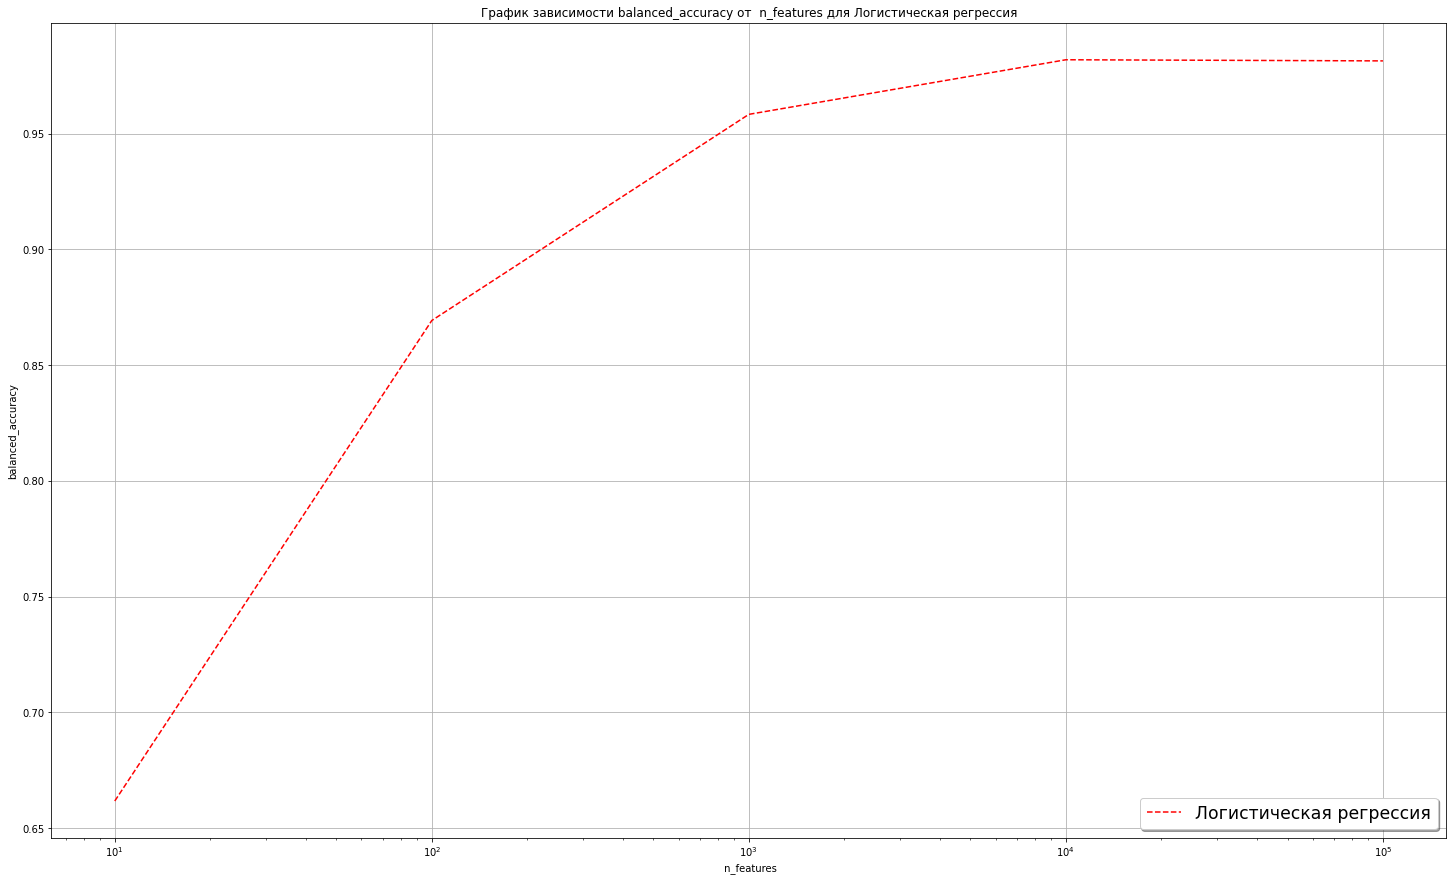

In [268]:
scores_test_logreg=[]
for c in  n_features:
  pipeline = Pipeline([
                        ("hashing", HashingVectorizer(norm=None,alternate_sign=False,n_features =int(c), ngram_range=(1,1))),
                       ("transformer", TfidfTransformer()),
                        ("knn_model", LogisticRegression(penalty="l2", fit_intercept=True, max_iter=100, C=df_3.iloc[3]['Value_best'], solver="lbfgs", random_state=12345))
  ])
  score = cross_validate(pipeline, X_train, y_train, cv=kf, scoring=['balanced_accuracy'])
  balanced_accuracy_model = score['test_balanced_accuracy'].mean()
  scores_test_logreg.append(balanced_accuracy_model)
plt.figure(1, figsize=[25, 15])
plt.plot( n_features, scores_test_logreg, color="red", label = 'Логистическая регрессия', ls = 'dashed')
plt.xlabel(" n_features")
plt.ylabel("balanced_accuracy")
plt.title('График зависимости balanced_accuracy от  n_features для Логистическая регрессия')
plt.grid(True)
plt.xscale('log')
plt.legend(loc=4, shadow=True, fontsize='xx-large')

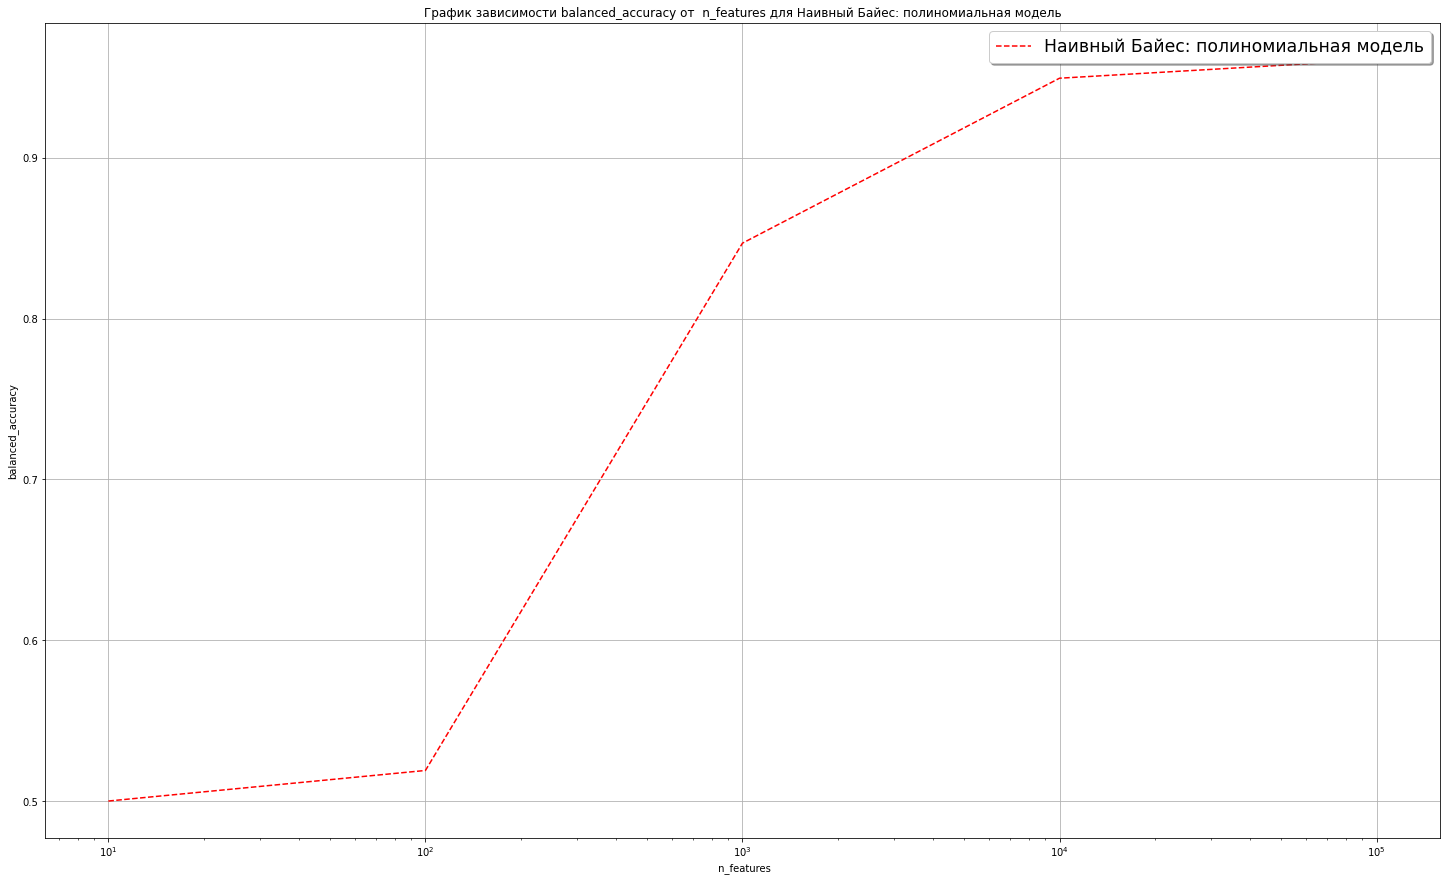

In [269]:
scores_test_multNB = []
for alpha in  n_features:
  pipeline = Pipeline([
                        ("hashing", HashingVectorizer(norm=None,alternate_sign=False,n_features =int(alpha), ngram_range=(1,1))),
                       ("transformer", TfidfTransformer()),
                        ("knn_model",  MultinomialNB(alpha=df_3.iloc[6]['Value_best']))
  ])
  score = cross_validate(pipeline, X_train, y_train, cv=kf, scoring=['balanced_accuracy'])
  balanced_accuracy_model = score['test_balanced_accuracy'].mean()
  scores_test_multNB.append(balanced_accuracy_model)




plt.figure(1, figsize=[25, 15])
plt.plot( n_features, scores_test_multNB, color="red", label = 'Наивный Байес: полиномиальная модель', ls = 'dashed')
plt.xlabel(" n_features")
plt.ylabel("balanced_accuracy")
plt.title('График зависимости balanced_accuracy от  n_features для Наивный Байес: полиномиальная модель')
plt.grid(True)
plt.xscale('log')
plt.legend(loc=1, shadow=True, fontsize='xx-large')

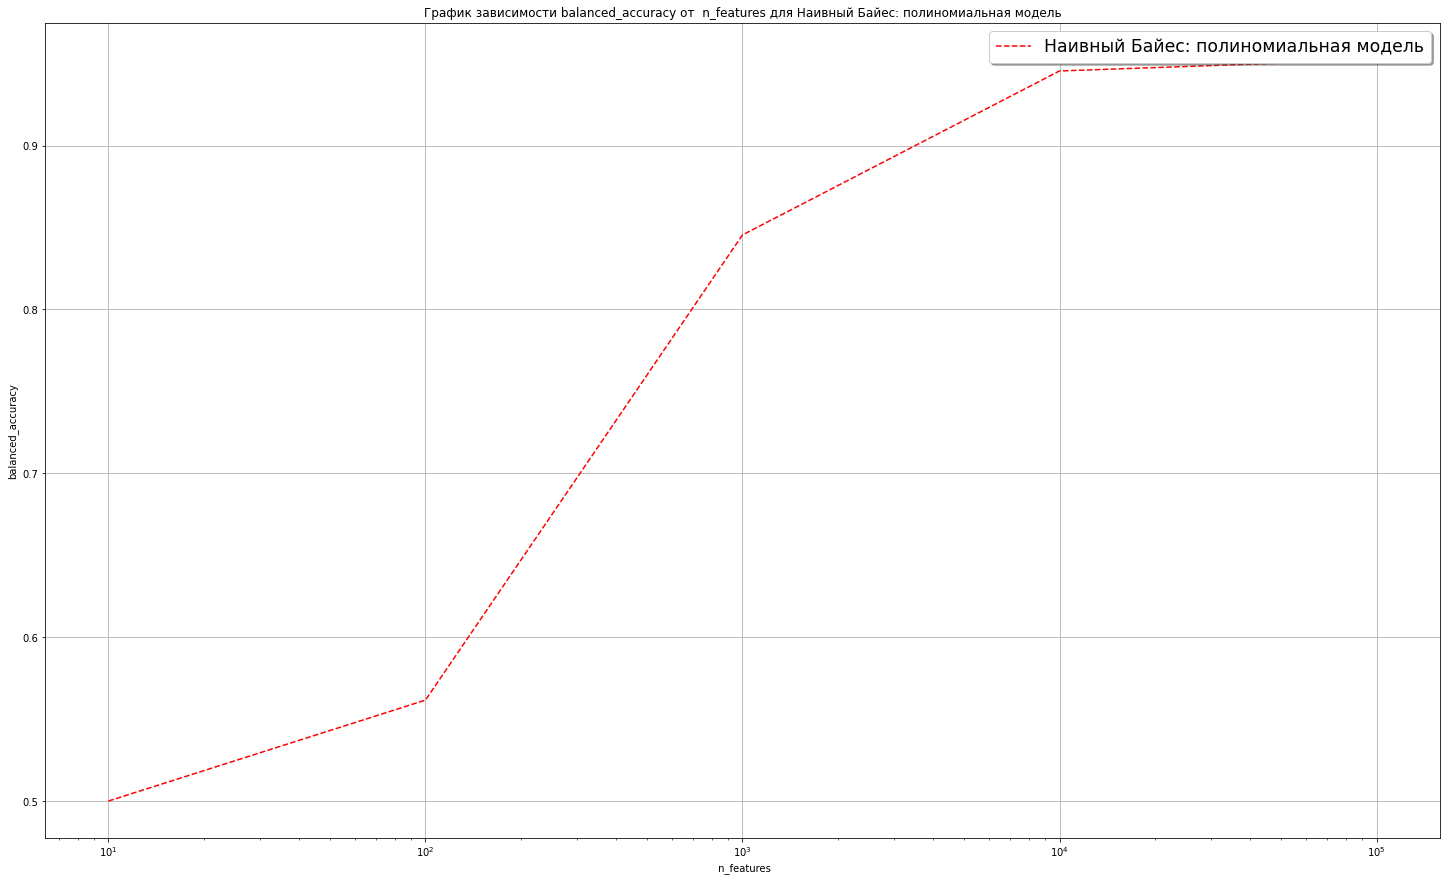

In [270]:
scores_test_bernNB=[]
for n in n_features:
  pipeline = Pipeline([
                        ("hashing", HashingVectorizer(norm=None,alternate_sign=False,n_features =int(n), ngram_range=(1,1))),
                       ("transformer", TfidfTransformer()),
                        ("knn_model",  BernoulliNB(alpha=df_3.iloc[9]['Value_best'], binarize=None))
  ])
  score = cross_validate(pipeline, X_train, y_train, cv=kf, scoring=['balanced_accuracy'])
  balanced_accuracy_model = score['test_balanced_accuracy'].mean()
  scores_test_bernNB.append(balanced_accuracy_model)
plt.figure(1, figsize=[25, 15])
plt.plot( n_features, scores_test_bernNB, color="red", label = 'Наивный Байес: полиномиальная модель', ls = 'dashed')
plt.xlabel(" n_features")
plt.ylabel("balanced_accuracy")
plt.title('График зависимости balanced_accuracy от  n_features для Наивный Байес: полиномиальная модель')
plt.grid(True)
plt.xscale('log')
plt.legend(loc=1, shadow=True, fontsize='xx-large')